In [1]:
import train
import disc_func
import decision_tree
import similarity
import fetch
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# run pip install aif360
from sklearn.model_selection import train_test_split
from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score
import time


def reload_modules():
    importlib.reload(train)
    importlib.reload(disc_func)
    importlib.reload(decision_tree)
    importlib.reload(similarity)

pip install 'aif360[LawSchoolGPA]'


In [2]:
# Fetch dataset
X, y, Xy, columns, class_names, disc_index = fetch.fraud()
print(disc_index)
# adult, bank, compas (race/sex), german (foreign/sex) , credit(sex/marital), fraud

4


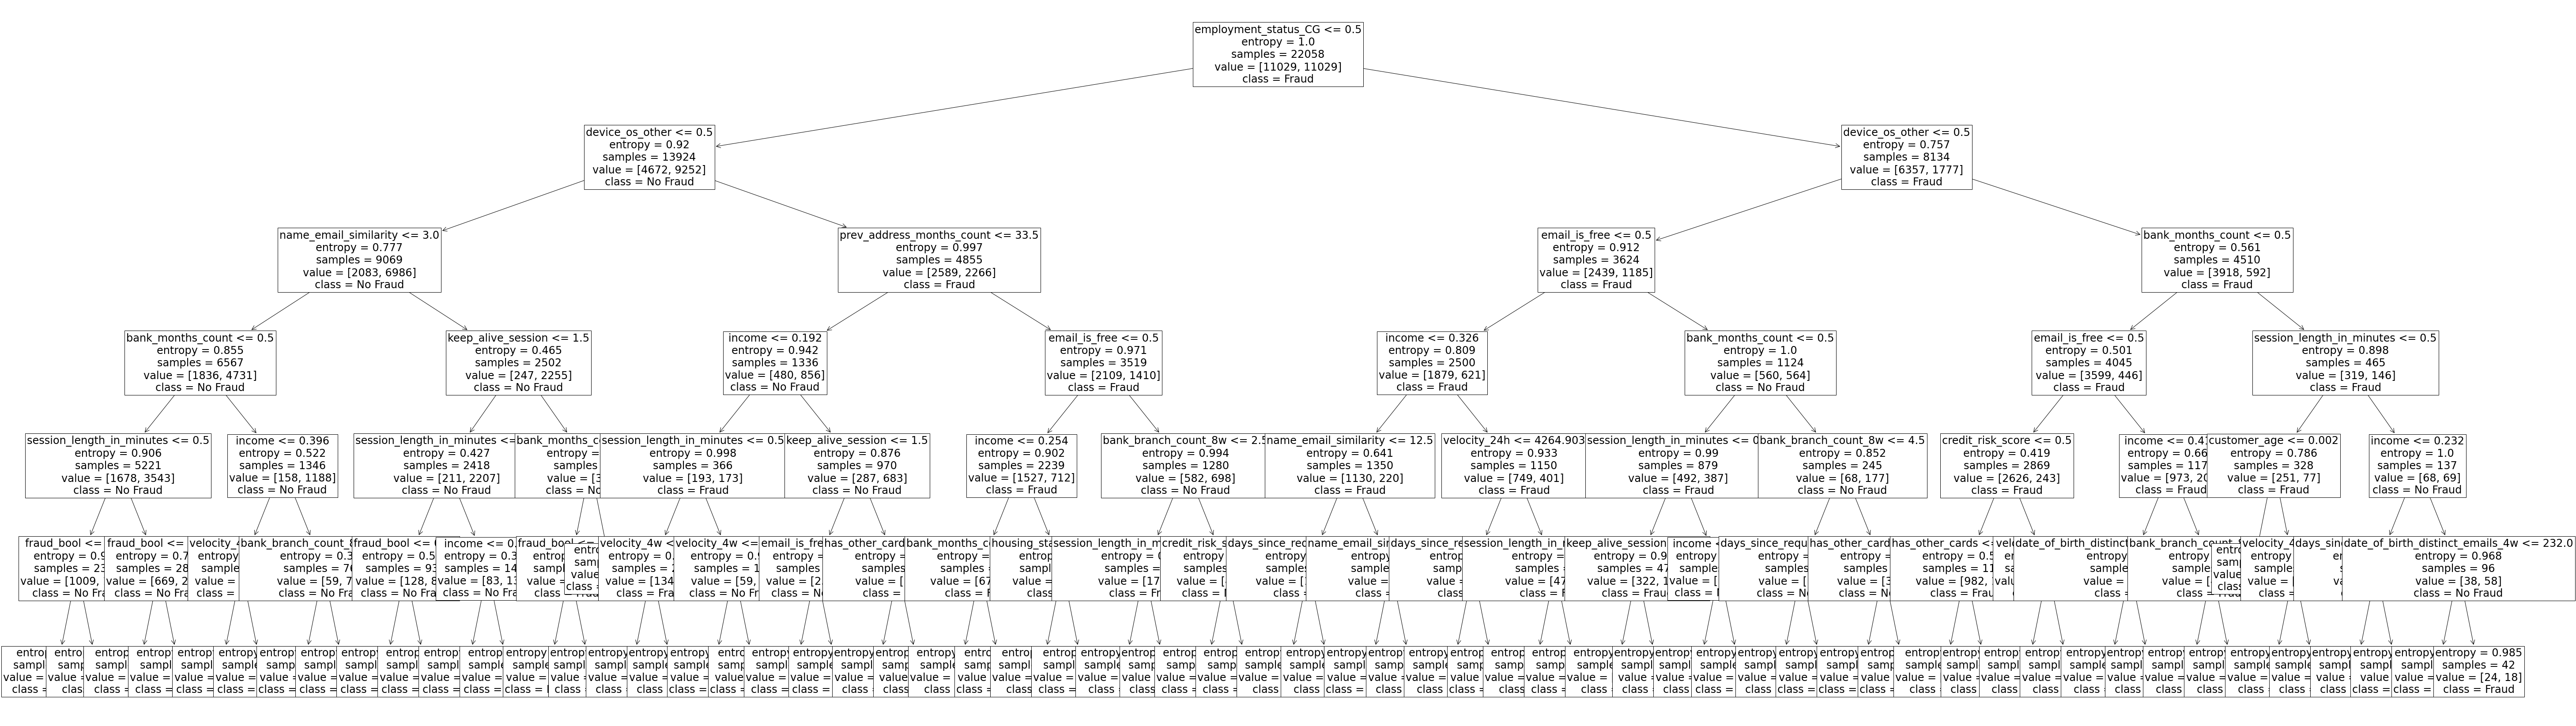

In [4]:
# Create a discriminative (but accurate) tree via sklearn
clf = tree.DecisionTreeClassifier(max_depth=6, criterion='entropy')
clf = clf.fit(X, y)
plt.figure(figsize=(100,30))
tree.plot_tree(clf, fontsize=24, feature_names=columns, class_names=class_names)
plt.show()
tree_dict = decision_tree.export_dict(clf)
for data in Xy:
    tree_dict.add_data(data)

In [18]:
def retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_calc, disc_func=disc_func.discrimination, criterion='gini'):
    def retrain(dec_tree, bad_node, train_method, disc_func, criterion):
        print('bad node:', bad_node.visual_json(disc_index, disc_func, attributes=columns))
        print('bad node accuracy:', bad_node.accuracy(), 'discrimination:', bad_node.discrimination(disc_index))
        good_node = bad_node.retrain_node(depth=None, train_method=train.gain_disc_priority, disc_index=disc_index, criterion=criterion)
        good_node.simplify()
        print('good node', good_node.visual_json(disc_index, disc_func, attributes=columns))
        for data in bad_node.data:
            good_node.add_data(data[:-1])
        print('good node accuracy:', good_node.accuracy(), 'discrimination:', good_node.discrimination(disc_index))
        if bad_node.unique_id == dec_tree.unique_id:
            dec_tree = good_node
        else:
            parent_node = dec_tree.get_parent(bad_node.unique_id, bad_node.get_height()+1)
            if parent_node == None:
                parent_node = dec_tree.get_parent(bad_node.unique_id)
            parent_node.replace_child(bad_node.unique_id, good_node)
        dec_tree.reset_data()
        for data in Xy:
            dec_tree.add_data(data)
        print('\nAccuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')
        return dec_tree

    dec_tree = tree_dict.copy()
    dec_tree.simplify()
    for data in Xy:
        dec_tree.add_data(data)
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))
    print('BEFORE: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index),'\n')

    bad_nodes = target_method(dec_tree, target, disc_index, disc_func=disc_func)
    if type(bad_nodes) == list:
        for bad_node in bad_nodes:
            if bad_node.unique_id == dec_tree.unique_id:
                continue
            dec_tree = retrain(dec_tree, bad_node, train_method, disc_func, criterion)
    else: 
        prev_node = dec_tree
        while(dec_tree.discrimination(disc_index, disc_func) < target):
            bad_nodes = target_method(dec_tree, target, disc_index, disc_func=disc_func)
            if bad_nodes.unique_id == dec_tree.unique_id:
                bad_node_less = target_method(dec_tree.less_node, target, disc_index, disc_func=disc_func)
                bad_node_greater = target_method(dec_tree.greater_node, target, disc_index, disc_func=disc_func)
                if bad_node_less.discrimination(disc_index) < bad_node_greater.discrimination(disc_index, disc_func):
                    bad_nodes = bad_node_less
                else:
                    bad_nodes = bad_node_greater
            if bad_nodes.unique_id == prev_node.unique_id or bad_nodes.discrimination(disc_index, disc_func) > target:
                break
            dec_tree = retrain(dec_tree, bad_nodes, train_method, disc_func, criterion)
            prev_node = bad_nodes

    print('\nAFTER: accuracy', dec_tree.accuracy(), 'discrimination', dec_tree.discrimination(disc_index, disc_func))
    print('predictive similarity:', similarity.predictive_similarity(tree_dict.data, dec_tree.data), 'naive discounted similarity:', similarity.naive_discounted_similarity(tree_dict, dec_tree))
    print(dec_tree.visual_json(disc_index, disc_func, attributes=columns))
    return dec_tree

In [19]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=-0.1, target_method=decision_tree.get_worst_node, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='gini')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.305", "accuracy":"0.775","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.75","device_os_other":"0.5", "Left":{"discrimination":"-0.036", "accuracy":"0.784","name_email_similarity":"3.0", "Left":{"discrimination":"-0.035", "accuracy":"0.737","bank_months_count":"0.5", "Left":{"discrimination":"-0.055", "accuracy":"0.699","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.109", "accuracy":"0.622","fraud_bool":"0.85", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.003", "accuracy":"0.906","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"0.034", "accuracy":"0.714","bank_months_count":"0.5", "Left":{"discrimination":"0.029", "accuracy":"0.667","fraud_bool":"0.75", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.178", "accuracy":"0.686","prev_address_months_count":"33.5"

In [17]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=-0.1, target_method=decision_tree.get_worst_node, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='gini')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.305", "accuracy":"0.775","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.75","device_os_other":"0.5", "Left":{"discrimination":"-0.036", "accuracy":"0.784","name_email_similarity":"3.0", "Left":{"discrimination":"-0.035", "accuracy":"0.737","bank_months_count":"0.5", "Left":{"discrimination":"-0.055", "accuracy":"0.699","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.109", "accuracy":"0.622","fraud_bool":"0.85", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.003", "accuracy":"0.906","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"0.034", "accuracy":"0.714","bank_months_count":"0.5", "Left":{"discrimination":"0.029", "accuracy":"0.667","fraud_bool":"0.75", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.178", "accuracy":"0.686","prev_address_months_count":"33.5"

In [7]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=-0.05, target_method=decision_tree.get_worst_node, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='entropy')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.305", "accuracy":"0.775","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.75","device_os_other":"0.5", "Left":{"discrimination":"-0.036", "accuracy":"0.784","name_email_similarity":"3.0", "Left":{"discrimination":"-0.035", "accuracy":"0.737","bank_months_count":"0.5", "Left":{"discrimination":"-0.055", "accuracy":"0.699","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.109", "accuracy":"0.622","fraud_bool":"0.85", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.003", "accuracy":"0.906","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"0.034", "accuracy":"0.714","bank_months_count":"0.5", "Left":{"discrimination":"0.029", "accuracy":"0.667","fraud_bool":"0.75", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.178", "accuracy":"0.686","prev_address_months_count":"33.5"

In [8]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='gini')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.305", "accuracy":"0.775","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.75","device_os_other":"0.5", "Left":{"discrimination":"-0.036", "accuracy":"0.784","name_email_similarity":"3.0", "Left":{"discrimination":"-0.035", "accuracy":"0.737","bank_months_count":"0.5", "Left":{"discrimination":"-0.055", "accuracy":"0.699","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.109", "accuracy":"0.622","fraud_bool":"0.85", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.003", "accuracy":"0.906","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"0.034", "accuracy":"0.714","bank_months_count":"0.5", "Left":{"discrimination":"0.029", "accuracy":"0.667","fraud_bool":"0.75", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.178", "accuracy":"0.686","prev_address_months_count":"33.5"

In [9]:
start_time = time.time()
new_tree = retrain_tree(tree_dict, target=None, target_method=decision_tree.get_bad_nodes_child_method, train_method=train.gain_disc_priority, disc_func=disc_func.discrimination, criterion='entropy')
print("\nNew Disc:",new_tree.discrimination(disc_index, disc_func.discrimination),"Old Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination),"Delta Disc:",tree_dict.discrimination(disc_index, disc_func.discrimination)-new_tree.discrimination(disc_index, disc_func.discrimination))
print("New Acc:",new_tree.accuracy(),"Old Acc:",tree_dict.accuracy(), "Delta Acc:", tree_dict.accuracy()-new_tree.accuracy())
print("Took", time.time()-start_time, 'seconds')

{"discrimination":"-0.305", "accuracy":"0.775","employment_status_CG":"0.5", "Left":{"discrimination":"-0.143", "accuracy":"0.75","device_os_other":"0.5", "Left":{"discrimination":"-0.036", "accuracy":"0.784","name_email_similarity":"3.0", "Left":{"discrimination":"-0.035", "accuracy":"0.737","bank_months_count":"0.5", "Left":{"discrimination":"-0.055", "accuracy":"0.699","session_length_in_minutes":"0.5", "Left":{"discrimination":"-0.109", "accuracy":"0.622","fraud_bool":"0.85", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}, "Right":{"class":1.0}}, "Right":{"discrimination":"-0.003", "accuracy":"0.906","keep_alive_session":"1.5", "Left":{"class":1.0}, "Right":{"discrimination":"0.034", "accuracy":"0.714","bank_months_count":"0.5", "Left":{"discrimination":"0.029", "accuracy":"0.667","fraud_bool":"0.75", "Left":{"class":1.0}, "Right":{"class":0.0}}, "Right":{"class":1.0}}}}, "Right":{"discrimination":"-0.178", "accuracy":"0.686","prev_address_months_count":"33.5"